In [1]:
from collections import namedtuple
from functools import partial
import palettable
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from plotting_utils import remove_spines, save_figure

/Users/ocsicnarf/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%matplotlib inline
set1_colors     = palettable.colorbrewer.qualitative.Set1_9.mpl_colors
dark2_colors    = palettable.colorbrewer.qualitative.Dark2_8.mpl_colors
paired12_colors = palettable.colorbrewer.qualitative.Paired_12.mpl_colors

In [3]:
run_name = 'wcv-trial-kenya-e-0.1'
num_trials = 5
output_dir = '../outputs/{}/'.format(run_name)

In [4]:
save_fig = partial(save_figure, folder=output_dir + 'figures', exts=['pdf', 'png'], dpi=300)

In [5]:
with open(output_dir + 'configuration/configuration.json') as f:
    config = json.load(f, object_hook=lambda d: namedtuple('Config', d.keys())(*d.values()))
serotypes = json.load(open(output_dir + 'configuration/' + config.serotype.serotypes_file))['serotypes']
num_serotypes = len(serotypes)
max_age = config.population.max_age
num_years = config.simulation.num_years_burn_in.demographic + config.simulation.num_years_burn_in.epidemiologic + config.simulation.num_years_simulation + 1

Extract serogroups

In [6]:
serogroups = [re.search('(\d+)\w*', s).group(1) for s in serotypes]

In [7]:
get_sg = lambda st: re.search('(\d+)\w*', st).group(1)

### Estimated Prevalences from Multiple Runs Compared to Observed

Note: prevalence is in children under 5

In [8]:
def read_csv(filename):
    return np.array(pd.read_csv(filename, header=None))

In [9]:
def get_estimated_prevalences(trial_number, year=-1):
    trial_dir = os.path.join(output_dir, 'trial-{}/'.format(trial_number))
    num_hosts_by_age = read_csv(os.path.join(trial_dir, 'num_hosts_by_age.csv'))
    num_hosts_under_5 = num_hosts_by_age[:,:5].sum(axis=1)

    num_colonized_under_5_ss = np.zeros(shape=(num_years, num_serotypes))
    for i in range(num_serotypes):
        num_colonized_under_5_ss[:,i] = read_csv(os.path.join(trial_dir, 'num_colonized_by_age_ss_' + serotypes[i] + '.csv'))[:,:5].sum(axis=1)

    estimated_prevalences = num_colonized_under_5_ss[year,:] / num_hosts_under_5[year]
    return estimated_prevalences

Get observed prevalences

In [10]:
observed_counts_file = '/Users/ocsicnarf/Github/Pneumo-Model/configuration/observed_counts_kenya_prevaccine.json' 
#output_dir + 'configuration/' + config.fitting.observed_counts_file

In [11]:
observed_counts = json.load(open(observed_counts_file))['counts']
prevalences = pd.DataFrame({'observed': np.array(observed_counts[:-1]) / np.sum(observed_counts).astype(float)}, index=serotypes)

Get prevalences each simulation trial

In [12]:
%%time
YEAR = 140
for i in range(num_trials):
    prevalences['trial-{}'.format(i)] = get_estimated_prevalences(i, YEAR)

CPU times: user 2.02 s, sys: 151 ms, total: 2.17 s
Wall time: 2.3 s


Get vaccine types for annotation

In [13]:
vaccine_types = {}
for v in config.vaccines:
    vaccine_types[v.name] = v.susceptibility_reduction.serotypes

AttributeError: 'Config' object has no attribute 'susceptibility_reduction'

In [14]:
targeted_serotypes = {}
#for program in config.simulation.vaccinations:
#    targeted_serotypes[program.vaccine] = vaccine_types[program.vaccine]

Plot

['../outputs/wcv-trial-kenya-e-0.1/figures/simulated-vs-observed-year-140-0.pdf',
 '../outputs/wcv-trial-kenya-e-0.1/figures/simulated-vs-observed-year-140-0.png']

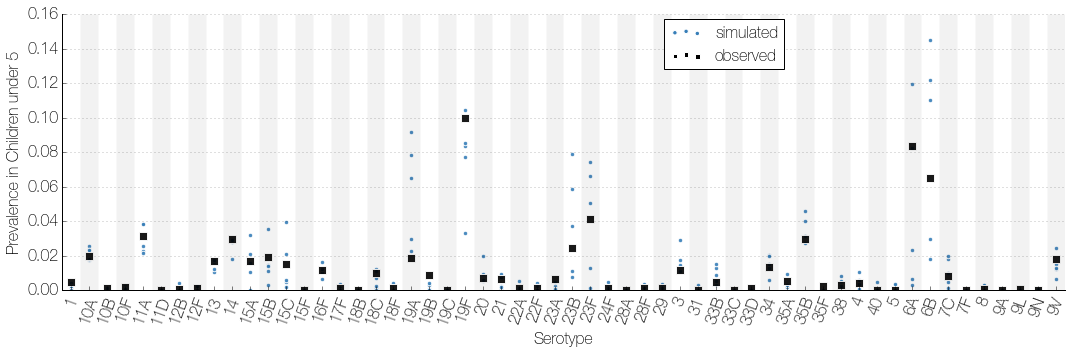

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

get_observed = lambda s: prevalences.loc[s].observed
get_estimates = lambda s: [prevalences.loc[s]['trial-{}'.format(i)] for i in range(num_trials)]

for i, s in enumerate(serotypes):
    ax.scatter(np.repeat(i, num_trials), get_estimates(s), c=set1_colors[1], alpha=0.9)
    ax.scatter(i, get_observed(s), c='k', s=50, marker='s', alpha=0.9)

for i, s in enumerate(serotypes):
  if i % 2:
    ax.axvspan(i - 0.5, i + 0.5, fc='k', alpha=0.05)
  
for i, s in enumerate(serotypes):
    # label serotype if it is targeted by a vaccination program
    for vac, vac_types in targeted_serotypes.iteritems():
        if s in vac_types:
            ax.axvspan(i - 0.5, i + 0.5, fc='k', alpha=0.1)
            ax.text(i, ax.get_ylim()[1], vac, ha='right', va='top', fontsize=9, rotation=-90)
        elif get_sg(s) in set(get_sg(t) for t in vac_types):
            ax.axvspan(i - 0.5, i + 0.5, fc='r', alpha=0.1)
            ax.text(i, ax.get_ylim()[1], 'VRT'.format(vac), ha='right', va='top', fontsize=9, rotation=-90)
            
ax.scatter(None, None, c=set1_colors[1], label='simulated')
ax.scatter(None, None, c='k', label='observed', marker='s')
ax.legend(loc=(0.6, 0.8), frameon=True)
    
ax.set_xlim(-0.5, num_serotypes - 0.5)
ax.set_ylim(0)
ax.yaxis.grid(which='major', alpha=0.5)
ax.set_xticks(np.arange(num_serotypes))
ax.set_xticklabels(serotypes, rotation=70)
ax.set_ylabel('Prevalence in Children under 5')
ax.set_xlabel('Serotype')

remove_spines(ax)
fig.tight_layout()
save_fig(fig, 'simulated-vs-observed-year-{}'.format(YEAR))

### Timecourses of Vaccine Types and Non-vaccine Types

Not implemented

### Fitter ranks with increasing serogroup immunity (from fitting to US data)

This should really be its own notebook

In [290]:
serotypes_sparc2 = json.load(open("../configuration/serotypes_sparc2.json"))['serotypes']
ranks_30 = json.load(open("../configuration/ranks-us-no-age-mixing-0.3-sg-30-halflife.json"))['ranks']
ranks_500 = json.load(open("../configuration/ranks-us-no-age-mixing-0.3-sg-500-halflife.json"))['ranks']
ranks_1000 = json.load(open("../configuration/ranks-us-no-age-mixing-0.3-sg-1000-halflife.json"))['ranks']
ranks_4000 = json.load(open("../configuration/ranks-us-no-age-mixing-0.3-sg-4000-halflife.json"))['ranks']
ranks_inf = json.load(open("../configuration/ranks-us-no-age-mixing-0.3-sg.json"))['ranks']

In [291]:
ranks_df = pd.DataFrame({30: ranks_30, 500: ranks_500, 1000: ranks_1000, 4000: ranks_4000, 'inf': ranks_inf}, index=serotypes_sparc2)

In [292]:
ranks_df.head()

,30,500,1000,4000,inf
10,9.032824,9.576236,9.236355,9.991998,9.851905
11A,5.530483,5.459044,5.537561,6.109559,6.169797
13,40.000000,40.000000,40.000000,40.000000,40.000000
14,7.932141,8.374397,8.472059,8.995644,8.904071
15A,12.445500,12.414800,12.228100,11.532230,10.143430


In [293]:
halflifes = ranks_df.columns
num_serotypes = len(serotypes_sparc2)

In [294]:
ranks_df.ix['11A', 30]

5.5304829999999994

In [295]:
get_serogroup = lambda s: int(re.search('(\d+)\D*', s).group(1))
serogroups_sparc2 = [get_serogroup(s) for s in serotypes_sparc2]
has_sibling = [serogroups_sparc2.count(get_serogroup(s)) > 1 for s in serotypes_sparc2]

['../figures/ranks-vs-sg-halflife-4.pdf']

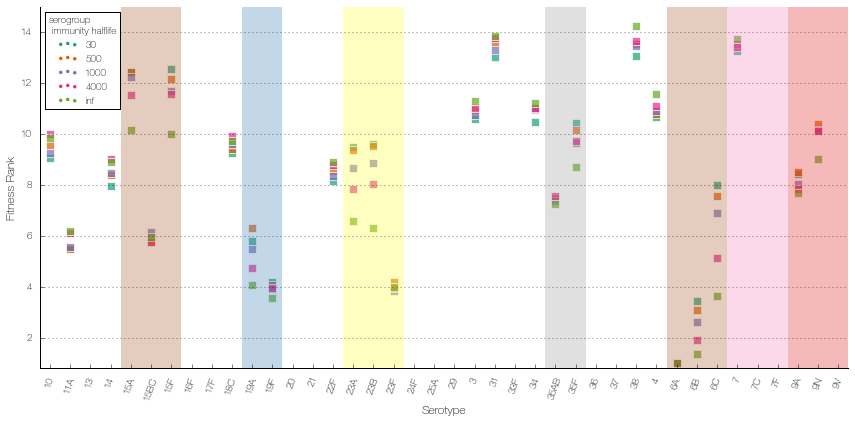

In [298]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = dark2_colors[:4]
for s in range(num_serotypes):
  for i, h in enumerate(halflifes):
    ax.scatter(s, ranks_df.iloc[s, i], c=dark2_colors[i], s=80, marker='s', alpha=0.7)
  ax.axvspan(s - 0.5, s + 0.5, ec='none', fc=set1_colors[serogroups_sparc2[s] % len(set1_colors)], alpha=(0.3 if has_sibling[s] else 0.0))

for i, h in enumerate(halflifes):
  ax.scatter(None, None, c=dark2_colors[i], label=h)
lgd = ax.legend(title='serogroup\n immunity halflife', frameon=True, loc='upper left')

ax.set_xlim(-0.5, num_serotypes - 0.5)
ax.set_xticks(np.arange(num_serotypes))
ax.set_xticklabels(ranks_df.index, rotation=70)

ax.set_ylim(0.8, 15)
ax.set_ylabel('Fitness Rank')
ax.set_xlabel('Serotype')
ax.yaxis.grid(True, which='major')

remove_spines(ax)
fig.tight_layout()
save_figure(fig, 'ranks-vs-sg-halflife')